In [4]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("..")

import keras
import keras.preprocessing.image
from keras_retinanet.models.resnet import custom_objects
from keras_retinanet.preprocessing.videotag import VIDEOtagGenerator

import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time
import json
import skimage.io

import tensorflow as tf

def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    return tf.Session(config=config)

# os.environ["CUDA_VISIBLE_DEVICES"] = "0"
keras.backend.tensorflow_backend.set_session(get_session())


args_input_json = '../dataset/videotag/0101_0102/instances.json'
args_image_dir = '../dataset/videotag/0101_0102/images'
args_output_json = '../dataset/videotag/0101_0102/result/instances.json'
FILE_CATEGORY_MAP = "../assets/json/category.json"
ROOT_DIR = os.getcwd()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
model = keras.models.load_model('/Users/luke/Documents/ml_models/resnet50_coco_best_v1.2.2.h5', custom_objects=custom_objects)
# mymodel = keras.models.load_model('/Users/luke/Documents/ml_models/resnet50_coco_01.h5', custom_objects=custom_objects)

/Users/luke/.pyenv/versions/3.6.3/envs/py36/lib/python3.6/site-packages/keras/models.py:274: UserWarning: Output "non_maximum_suppression_2" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "non_maximum_suppression_2" during training.
  sample_weight_mode=sample_weight_mode)


In [5]:


coco_class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
                'bus', 'train', 'truck', 'boat', 'traffic light',
                'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
                'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
                'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
                'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
                'kite', 'baseball bat', 'baseball glove', 'skateboard',
                'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
                'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
                'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
                'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
                'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
                'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
                'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
                'teddy bear', 'hair drier', 'toothbrush']


###################################################################
# Load VIDEOtag, COCO category 맵핑 데이타
# COCO Model에서 검출된 class와 VIDEOtag에 미리 정해져 있는 class매칭을 위해 사용
###################################################################
map_data = open(FILE_CATEGORY_MAP).read()
tmp_vt_coco_cate_map = json.loads(map_data)["categories"]

# NOTE : 빠른 검색을 위해 dictionary로 생성
vt_coco_cate_map = {}
for cate_data in tmp_vt_coco_cate_map:
    vt_coco_cate_map[cate_data['id']] = cate_data


json_data = open(args_input_json).read()
data = json.loads(json_data)

# NOTE : VIDEOtag Data (원본)
vt_anno_ary = data['annotations']
vt_img_ary = data['images']
vt_cate_ary = data['categories']

# NOTE : VIDEOtag Data (검색용)
vt_anno_ids_of_imageids = {}
vt_anno_dic = {}
vt_cate_ary_dic = {}

for anno in vt_anno_ary:
    vt_anno_dic[anno['id']] = anno

for cate in vt_cate_ary:
    vt_cate_ary_dic[cate['id']] = cate

for image in vt_img_ary:
    anno_ids = []
    image_id = image['id']

    for anno in vt_anno_ary:
        anno_img_id = anno['image_id']
        anno_id = anno['id']
        if anno_img_id == image_id:
            anno_ids.append(anno_id)

    vt_anno_ids_of_imageids[image_id] = anno_ids

def getAnnosByImgId(img_id):
    anno_ids = vt_anno_ids_of_imageids[img_id]
    result = []
    for anno_id in anno_ids:  
        result.append(vt_anno_dic[anno_id])

    return result

def insertBboxToAnno(anno_id, bbox):
    for anno in vt_anno_ary:
        if anno['id'] == anno_id:
            anno['bbox'] = bbox
            return anno
            break

0/1081
1/1081
2/1081
3/1081
4/1081
5/1081
6/1081
7/1081


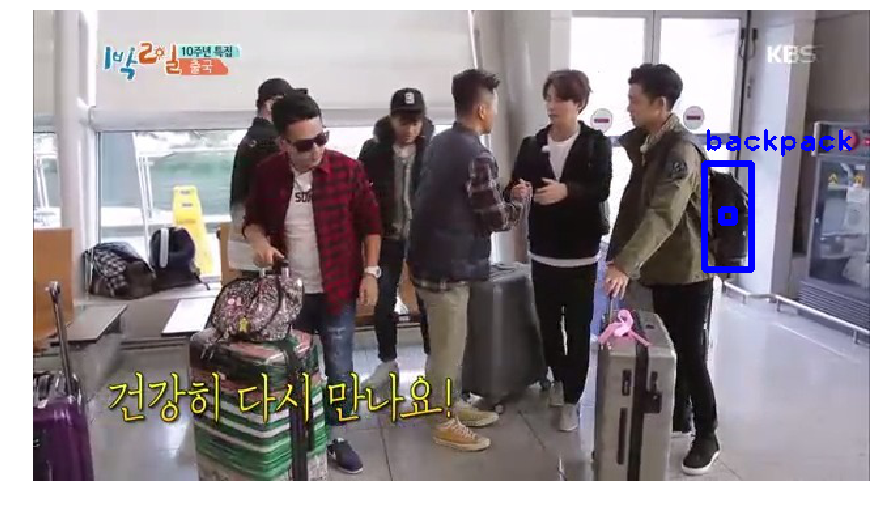

매칭된 카테고리 확인 -  [['backpack', '가방']]
----------------------------------------------------------------------
8/1081
9/1081
10/1081
11/1081
12/1081
13/1081
14/1081
15/1081
16/1081
17/1081
18/1081
19/1081
20/1081
21/1081
22/1081
23/1081
24/1081
25/1081
26/1081
27/1081
28/1081
29/1081
30/1081
31/1081
32/1081
33/1081
34/1081
35/1081
36/1081
37/1081
38/1081
39/1081
40/1081
41/1081
42/1081
43/1081


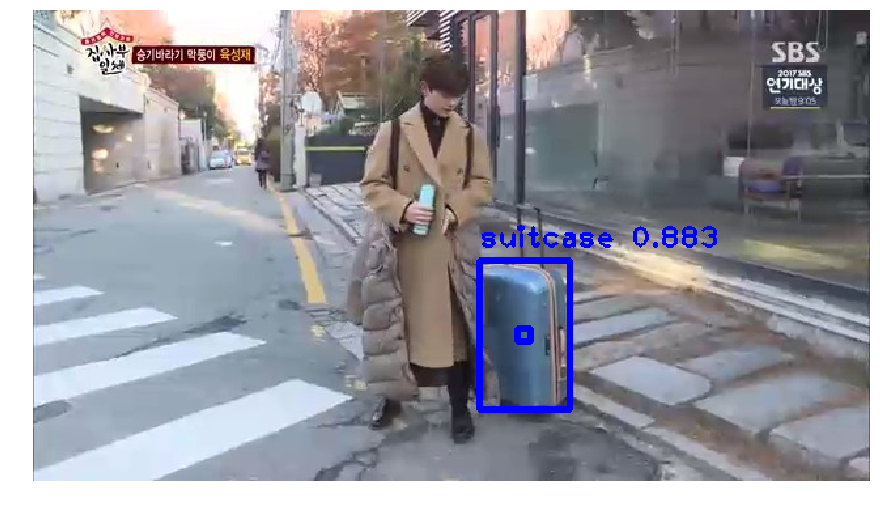

매칭된 카테고리 확인 -  [['suitcase', '가방']]
----------------------------------------------------------------------
44/1081
45/1081
46/1081
47/1081
48/1081
49/1081
50/1081
51/1081
52/1081
53/1081
54/1081
55/1081
56/1081
57/1081
58/1081
59/1081
60/1081
61/1081
62/1081
63/1081
64/1081
65/1081
66/1081
67/1081
68/1081
69/1081
70/1081
71/1081
72/1081
73/1081
74/1081
75/1081
76/1081
77/1081
78/1081
79/1081
80/1081
81/1081
82/1081
83/1081
84/1081
85/1081
86/1081
87/1081
88/1081
89/1081
90/1081
91/1081
92/1081
93/1081
94/1081
95/1081
96/1081
97/1081
98/1081
99/1081
100/1081
101/1081


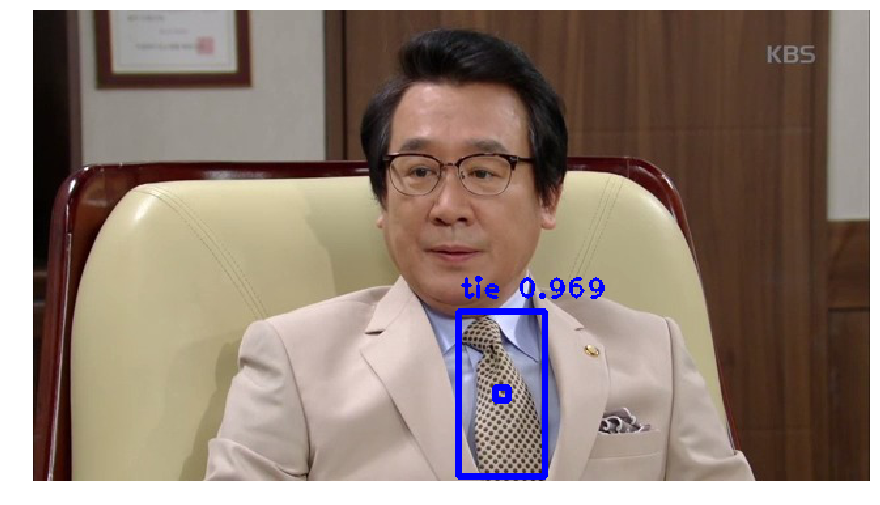

매칭된 카테고리 확인 -  [['tie', '넥타이']]
----------------------------------------------------------------------
102/1081
103/1081
104/1081
105/1081


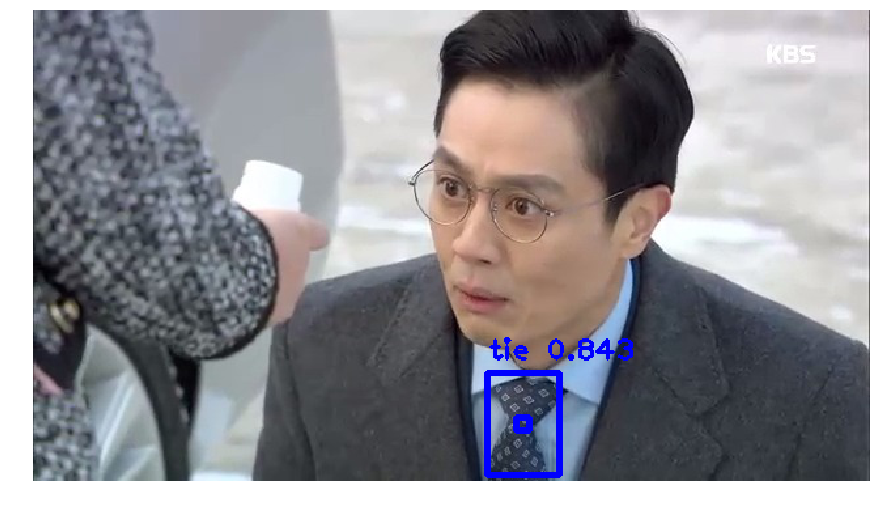

매칭된 카테고리 확인 -  [['tie', '넥타이']]
----------------------------------------------------------------------
106/1081
107/1081
108/1081
109/1081
110/1081
111/1081
112/1081
113/1081
114/1081
115/1081
116/1081


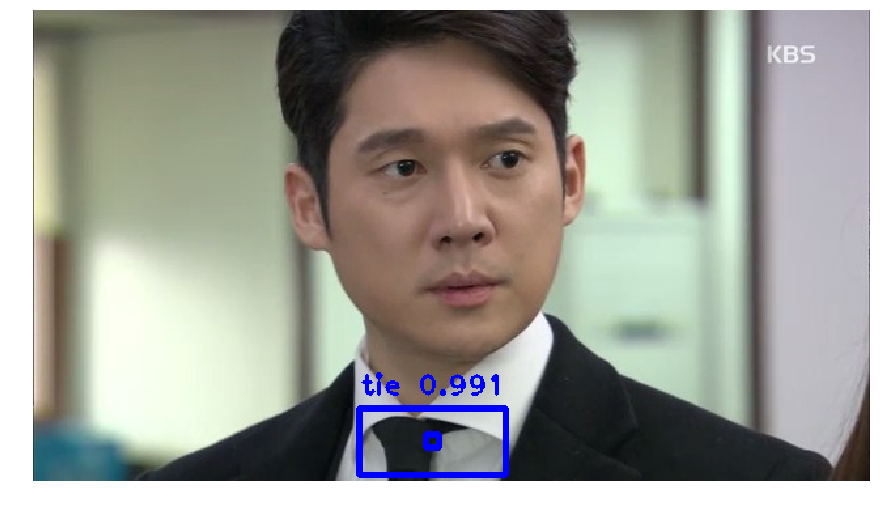

매칭된 카테고리 확인 -  [['tie', '넥타이']]
----------------------------------------------------------------------
117/1081
118/1081
119/1081
120/1081


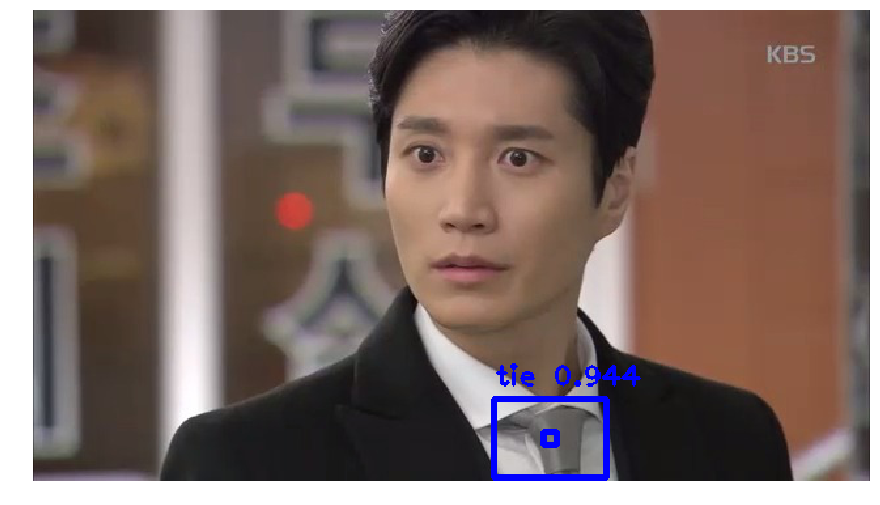

매칭된 카테고리 확인 -  [['tie', '넥타이']]
----------------------------------------------------------------------
121/1081
122/1081
123/1081
124/1081
125/1081
126/1081
127/1081
128/1081
129/1081
130/1081
131/1081
132/1081
133/1081
134/1081


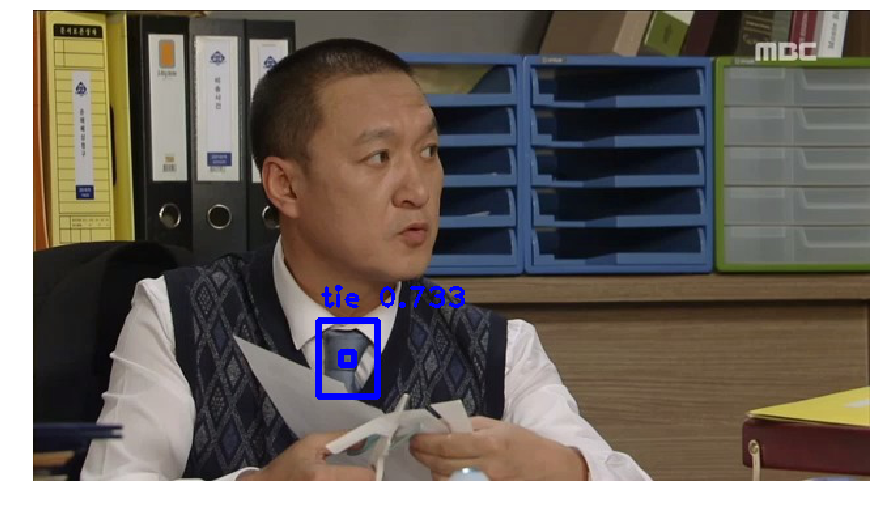

매칭된 카테고리 확인 -  [['tie', '넥타이']]
----------------------------------------------------------------------
135/1081
136/1081
137/1081
138/1081
139/1081
140/1081
141/1081
142/1081


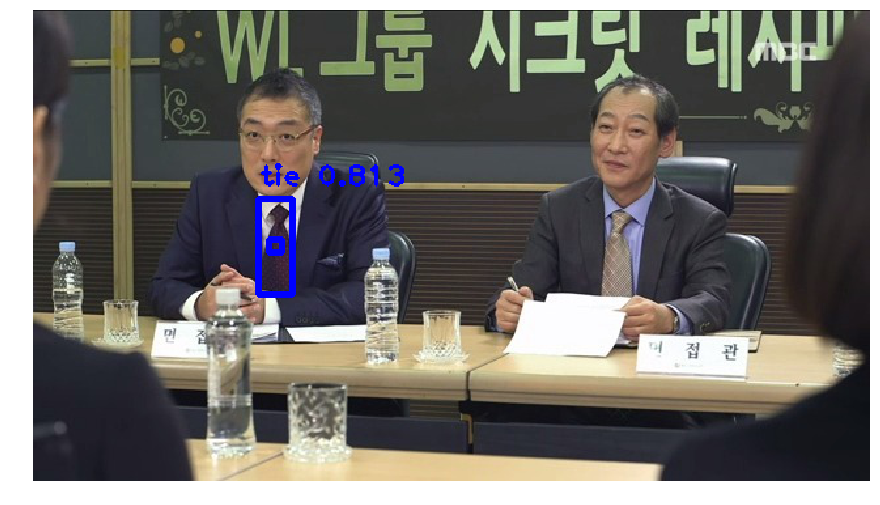

매칭된 카테고리 확인 -  [['tie', '넥타이']]
----------------------------------------------------------------------
143/1081
144/1081
145/1081
146/1081
147/1081
148/1081
149/1081
150/1081


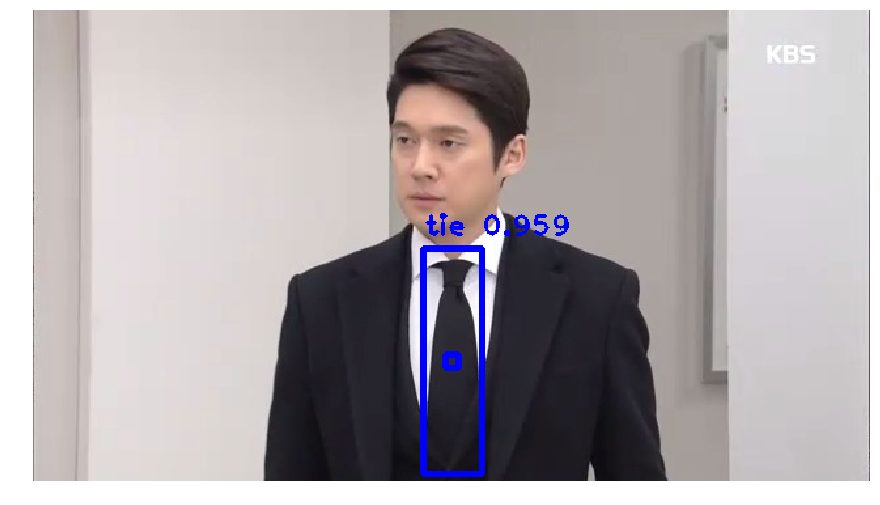

매칭된 카테고리 확인 -  [['tie', '넥타이']]
----------------------------------------------------------------------
151/1081
152/1081
153/1081
154/1081


In [ ]:
###################################################################
# 모든 이미지에 대하여 predict를 실시한다.
###################################################################
img_total = len(vt_img_ary)

for img_idx, img_data in enumerate(vt_img_ary): 
    # NOTE : d_ -> detected_, a_ -> answer_
    
#     if img_idx < 42:
#         continue
        
#     if img_idx > 100:
#         break

    print(str(img_idx)+'/'+str(img_total))
    img_id = img_data['id']

    ###################################################################
    # videotag image에 등록되어 있느 annotation이 있는지 확인 후, 로드
    ###################################################################
    a_vt_annos = getAnnosByImgId(img_id)

    if len(a_vt_annos) == 0:
        continue

    ###################################################################
    # videotag image이 로드
    ###################################################################
    img_path = os.path.join(ROOT_DIR, args_image_dir, img_data['file_name']) 
    image = skimage.io.imread(img_path)
    img_height, img_width = image.shape[:2]
    
    # If grayscale. Convert to RGB for consistency.
    if image.ndim != 3:
        image = skimage.color.gray2rgb(image)

    ###################################################################
    # Run detection
    ###################################################################
#     d_results = model.detect([image], verbose=0)
    _, _, detections = model.predict_on_batch(np.expand_dims(image, axis=0))
    
#     predicted_labels = np.argmax(detections[0, :, 4:], axis=1)
#     scores = detections[0, np.arange(detections.shape[1]), 4 + predicted_labels]

    # correct for image scale
#     detections[0, :, :4] /= scale


#     print(predicted_labels, scores)
    
    
    
#     draw = image.copy()
# #     draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)
#     # visualize detections
#     for idx, (label, score) in enumerate(zip(predicted_labels, scores)):
#         if score < 0.5:
#             continue
#         b = detections[0, idx, :4].astype(int)
#         cv2.rectangle(draw, (b[0], b[1]), (b[2], b[3]), (0, 0, 255), 3)
#         caption = "{} {:.3f}".format(coco_class_names[label+1], score)
#         cv2.putText(draw, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1.5, (0, 0, 0), 3)
#         cv2.putText(draw, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1.5, (0, 0, 255), 2)

#     # visualize annotations
#     # for annotation in annotations:
#     #     label = int(annotation[4])
#     #     b = annotation[:4].astype(int)
#     #     cv2.rectangle(draw, (b[0], b[1]), (b[2], b[3]), (0, 255, 0), 2)
#     #     caption = "{}".format(val_generator.label_to_name(label))
#     #     cv2.putText(draw, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1.5, (0, 0, 0), 3)
#     #     cv2.putText(draw, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1.5, (0, 255, 0), 2)

#     plt.figure(figsize=(15, 15))
#     plt.axis('off')
#     plt.imshow(draw)
#     plt.show()
    
#     break

    # Result
#     d_r = d_results[0]

#     d_rois = detections[0, idx, :4].astype(int)#d_r['rois'] # y1, x1, y2, x2
    d_coco_cate_ids = np.argmax(detections[0, :, 4:], axis=1)#d_r['class_ids']
    d_scores = detections[0, np.arange(detections.shape[1]), 4 + d_coco_cate_ids]#d_r['scores']


    # 확인용
    confirm_matching_classes = []
    confirm_vt_anno_points = []

    is_found = 0
    
    draw = image.copy()

    ###################################################################
    # 추출된 data를 VIDEOtag Annotation과 비교
    ###################################################################
    for d_idx, score in enumerate(d_scores):
        '''
        스코어 낮은 것은 의미가 없는 것으로 판단함
        아래에 VIDEOtag과 COCO의 데이타를 비교하는 로직이 있으므로 Predict의 정확도는
        현재 로직에서 의미가 없음
        '''
        
        if score < 0.7:
            continue

        d_coco_cate_id = d_coco_cate_ids[d_idx]+1
        d_coco_cate_name = coco_class_names[d_coco_cate_id]
        y1, x1, y2, x2 = detections[0, d_idx, :4].astype(int)
        d_bbox = [int(x1), int(y1), int(x2 - x1), int(y2 - y1)]
        
#         b = detections[0, d_idx, :4].astype(int)
#         cv2.rectangle(draw, (y1, x1), (y2, x2), (0, 0, 255), 3)
#         caption = "{} {:.3f}".format(d_coco_cate_name, score)
#         cv2.putText(draw, caption, (y1, x1 - 10), cv2.FONT_HERSHEY_PLAIN, 1.5, (0, 0, 0), 3)
#         cv2.putText(draw, caption, (y1, x1 - 10), cv2.FONT_HERSHEY_PLAIN, 1.5, (0, 0, 255), 2)
        
        
        ###################################################################
        # coco model에서 검출된 annotation들이 videotag annotation(정답)들과 비교하여
        # 일치할 경우가 있을 때, 해당 videotag annotation에 bbox정보를 추가한다.
        ###################################################################
        for a_vt_anno in a_vt_annos:
            a_vt_anno_id = a_vt_anno['id']
            a_vt_cate_id = a_vt_anno['category_id']
            a_vt_cate_name = vt_cate_ary_dic[a_vt_cate_id]['name']

            point_x = int(img_width * a_vt_anno['x_pos'])
            point_y = int(img_height * a_vt_anno['y_pos'])

            # NOTE : 기대하는 VIDEOtag의 coco categories 확인. 현재(2018.02) 매칭되는 category가 많지 않다.
            a_coco_cate_ids = vt_coco_cate_map[a_vt_cate_id]['coco_ids']
            if len(a_coco_cate_ids) == 0:
                continue

            # NOTE: 포인트가 마스크 영역에 속하는 확인
            if point_x < x1 and point_x > x2 and point_y < y1 and point_y > y2:
                continue

            for a_coco_cate_id in a_coco_cate_ids:
                if a_coco_cate_id == d_coco_cate_id:
                    insertBboxToAnno(a_vt_anno_id, d_bbox)
                    
                    cv2.rectangle(draw, (y1, x1), (y2, x2), (0, 0, 255), 3)
                    cx = int(x1 + (x2-x1)*0.5)
                    cy = int(y1 + (y2-y1)*0.5)
                    cv2.rectangle(draw, (cy-5, cx-5), (cy+5, cx+5), (0, 0, 255), 3)
                    caption = "{} {:.3f}".format(d_coco_cate_name, score)
                    cv2.putText(draw, caption, (y1, x1 - 10), cv2.FONT_HERSHEY_PLAIN, 1.5, (0, 0, 255), 2)
#                     print(d_bbox)
#                     print(img_width, img_height)

                    confirm_vt_anno_points.append([point_y-5, point_x-5, point_y+5, point_x+5])
                    confirm_matching_classes.append([d_coco_cate_name, a_vt_cate_name])
                    is_found = 1
                    break
                
    if len(confirm_vt_anno_points) > 0:
        plt.figure(figsize=(15, 15))
        plt.axis('off')
        plt.imshow(draw)
        plt.show()

    if len(confirm_matching_classes) > 0:
        print('매칭된 카테고리 확인 - ', confirm_matching_classes)
        print('----------------------------------------------------------------------')

In [55]:
result_json = {}
result_json['annotations'] = vt_anno_ary
result_json['images'] = vt_img_ary

with open('../dataset/videotag/0101_0102/result/instances.json', 'w') as outfile:
    json.dump(result_json, outfile)

FileNotFoundError: [Errno 2] No such file or directory: '../dataset/videotag/0101_0102/result/instances.json'